# Kinetics Project Validation Tool
## This notebook can be used to validate a model against experimental data
The following is the isothermal reaction under investigation:
$\require{mhchem}$
$$\ce{A ->[C] D + U}$$

where A is the starting reagent, C is the catalyst, D is the desired product, and U is the undesired product.
We can control the starting concentration of A, the concentration of C, and the reaction temperature.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import odeint
from scipy.optimize import curve_fit
from scipy.stats import linregress
%matplotlib inline

## Use the following cell to import tab-separated experiment data

In [2]:
def readdata(filename):
    return pd.read_csv(filename, sep="\t|[ ]{1,}", engine='python', skiprows=2, names=['Time', 'A', 'D', 'U'])
def readinit(filename):
    return pd.read_csv(filename, sep="\t|[ ]{1,}", engine='python', skiprows=1, names=['A', 'D', 'U', 'C', 'T'], nrows=1, usecols=range(2, 7))

In [3]:
filename = "data/exp1990.tsv"
init = readinit(filename)
exp = readdata(filename)
t_final = exp.Time.values[-1]
t_prefinal = exp.Time.values[-2]

## Use the following cell to assemble multiple experiment files for experiments performed at the same conditions

In [4]:
datadir = "data/"
extension = ".tsv"
filenames = ["exp1428", "exp1990", "exp1991", "exp1992"]
filenames = [datadir + i + extension for i in filenames]
init_concat = readinit(filenames[0]) # Make sure that initial conditions are the same for all files!
dataframes = [readdata(file) for file in filenames]

exp_times_concat = np.array([frame.Time.values for frame in dataframes]).flatten()
a_concat = np.array([frame.A.values for frame in dataframes]).flatten()
d_concat = np.array([frame.D.values for frame in dataframes]).flatten()
u_concat = np.array([frame.U.values for frame in dataframes]).flatten()
t_final_concat = max(exp_times_concat)

## We propose the following mechanism
$\require{mhchem}$
$$\ce{\alpha A <=>[k_1][k_{-1}] \beta_1 B}$$

$$\ce{\beta_2 B + \gamma C ->[k_2] \delta D + \gamma C}$$

$$\ce{\beta_3 B ->[k_3] \upsilon U}$$

A is the starting reagent, C is the catalyst, D is the desired product, and U is the undesired product.

The following rate laws will be tested.

$$-r_A = k_1 C_A^{\alpha} - k_{-1} C_B^{\beta_1}$$

$$r_D = k_2 C_B^{\beta_2} C_C^{\gamma}$$

$$r_U = k_3 C_B^{\beta_3}$$

$$r_B = -r_A - r_D - r_U$$

## Use the cell below to enter a rate law. Define all necessary constants

In [405]:
def dadt(cA, cB, alpha, beta1, k1, k_1):
    return k_1 * cB**beta1 - k1 * cA**alpha
    
def dudt(cB, beta3, k3):
    return k3 * cB**beta3

def dddt(cB, cC, beta2, gamma, k2):
    return k2 * cB**beta2 * cC**gamma

def rates(parms, time):
    """
    Returns the RHS of the system of ODEs
    """
    C_A, C_B, C_D, C_U, C_C = parms
    rateD = dddt(C_B, C_C, beta2, k1, k_1)
    rateU = dudt(C_B, beta3, k3)
    rateA = dadt(C_A, C_B, alpha, beta1, k1, k_1)
    rateB = -1 * rateA - rateD - rateU
    rateC = 0. # no catalyst depletion
    return (rateA, rateB, rateD, rateU, rateC)

def concentrations(cA0, cC0, T, time, params):
    """"
    This function calculates the concentrations of the reacting species using a proposed rate law
    cA (mol/L) is the initial concentration of reactant A
    cC (mol/L) is the initial catalyst concentration
    T (K) is the temperature
    time (s) is the elapsed reaction time
    Return values:
    time (s) array of times at which concentrations were calculated
    cA (mol/L) array of concentrations of A during the time interval
    cD (mol/L) array of concentrations of the desired product D during the time interval
    cU (mol/L) array of concentrations of the undesired product U during the time interval
    """
    
    try:
        alpha, beta1, beta2, beta3, gamma, k1, k_1, k2, k3 = params
    except:
        print("Params should contain at least 9 parameters!")
        return -1, -1, -1, -1,
    else:                

        
        times = np.linspace(0, time, 1000)
        
        result = odeint(rates, (cA0, 0., 0., 0., cC0), times)
        
        cA = result[:,0]
        cB = result[:,1]
        cD = result[:,2]
        cU = result[:,3]
        
    return times, cA, cD, cU, cB

## Integrate
Use the cell below to carry out the integration

In [423]:
alpha = 1.
beta1 = 1.
beta2 = 2.
beta3 = 2.
gamma = 1.
k1 = 0.12
k_1 = k1 / 0.308 # from equilibrium relationship
k2 = 1.
k3 = 0.50
times, A, D, U, B = concentrations(init.A, init.C, init.T, t_prefinal,
                                (alpha, beta1, beta2, beta3, gamma, k1, k_1, k2, k3))

In [424]:
times_concat, A_concat, D_concat, U_concat, B_concat = concentrations(init_concat.A,
                                                                      init_concat.C,
                                                                      init_concat.T,
                                                                      t_final_concat,
                                (alpha, beta1, beta2, beta3, gamma, k1, k_1, k2, k3))

## Compare
Compare to the experimental results below.

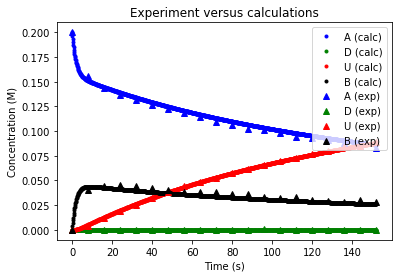

In [425]:
exp_possible_b = init.A.values[0] - (exp.A.values + exp.U.values) # mol/L of A unaccounted for (potential B)
# Plot experimental and calculated results on the same chart
plt.plot(times, A, 'b.', label='A (calc)')
plt.plot(times, D, 'g.', label='D (calc)')
plt.plot(times, U, 'r.', label='U (calc)')
plt.plot(times, B, 'k.', label='B (calc)')
plt.plot(exp.Time.values[:-1], exp.A.values[:-1], 'b^', label='A (exp)')
plt.plot(exp.Time.values[:-1], exp.D.values[:-1], 'g^', label='D (exp)')
plt.plot(exp.Time.values[:-1], exp.U.values[:-1], 'r^', label='U (exp)')
plt.plot(exp.Time.values[:-1], exp_possible_b[:-1], 'k^', label='B (exp)')
plt.legend(loc=1)
plt.title('Experiment versus calculations')
plt.xlabel('Time (s)')
plt.ylabel('Concentration (M)')
plt.show()

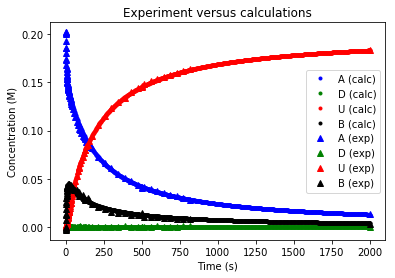

In [426]:
exp_possible_b_concat = init_concat.A.values[0] - (a_concat + u_concat) # mol/L of A unaccounted for (potential B)
# Plot experimental and calculated results on the same chart
plt.plot(times_concat, A_concat, 'b.', label='A (calc)')
plt.plot(times_concat, D_concat, 'g.', label='D (calc)')
plt.plot(times_concat, U_concat, 'r.', label='U (calc)')
plt.plot(times_concat, B_concat, 'k.', label='B (calc)')
plt.plot(exp_times_concat[:-1], a_concat[:-1], 'b^', label='A (exp)')
plt.plot(exp_times_concat[:-1], d_concat[:-1], 'g^', label='D (exp)')
plt.plot(exp_times_concat[:-1], u_concat[:-1], 'r^', label='U (exp)')
plt.plot(exp_times_concat[:-1], exp_possible_b_concat[:-1], 'k^', label='B (exp)')
plt.legend()
plt.title('Experiment versus calculations')
plt.xlabel('Time (s)')
plt.ylabel('Concentration (M)')
plt.show()

## Obtaining rates from experimental data

In [8]:
# 3-point differentiation of experimental [A], [U], and possible [B]
exp_a = exp.A.values[:-1] # ignore the last long-time value
exp_u = exp.U.values[:-1] # ignore the last long-time value
exp_t = exp.Time.values[:-1] # ignore the last long-time value
exp_missing_a = init.A.values[0] - (exp_a + exp_u) # mol/L of A unaccounted for (potential B)
delta_t = exp_t[1] - exp_t[0]
exp_ra = (np.diff(exp_a[:-1]) + np.diff(exp_a[1:])) / (2 * delta_t)
exp_ru = (np.diff(exp_u[:-1]) + np.diff(exp_u[1:])) / (2 * delta_t)
exp_r_missing_a = (np.diff(exp_missing_a[:-1]) + np.diff(exp_missing_a[1:])) / (2 * delta_t)

In [8]:
# 3-point differentiation of concatenated experimental [A], [U], and possible [B]
##### TO DO #####
#exp_ra = (np.diff(exp_a[:-1]) + np.diff(exp_a[1:])) / (2 * delta_t)
#exp_ru = (np.diff(exp_u[:-1]) + np.diff(exp_u[1:])) / (2 * delta_t)
#exp_r_missing_a = (np.diff(exp_missing_a[:-1]) + np.diff(exp_missing_a[1:])) / (2 * delta_t)

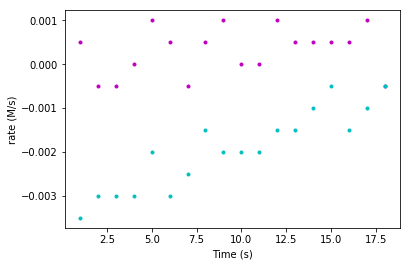

In [9]:
# Plot of dudt, dadt vs time
plt.plot(exp_t[1:-1], exp_ru, 'm.', exp_t[1:-1], exp_ra, 'c.')
plt.xlabel('Time (s)')
plt.ylabel('rate (M/s)')
plt.show()

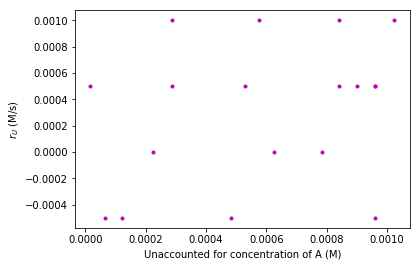

In [10]:
# Plot of du/dt against (missing_a)^2 (looks linear)
plt.plot(exp_missing_a[1:-1]**2, exp_ru, 'm.')
plt.xlabel('Unaccounted for concentration of A (M)')
plt.ylabel('$r_U$ (M/s)')

The above plot implies that $\beta_3 = 2$.

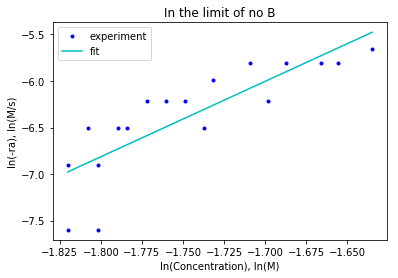

k1 =  2344.10618723 
alpha =  8.09644893549


In [11]:
# Plot of -(da/dt) against the concentration of A in the limit of no B
lnA_exp = np.log(exp_a[1:-1])
ln_ra_exp = np.log(-1*exp_ra)
alpha_fit, lnk1_fit, r_val, p_val, std_err = linregress(lnA_exp, ln_ra_exp)
plt.plot(lnA_exp, ln_ra_exp, 'b.', label='experiment')
plt.plot(lnA_exp, lnk1_fit + alpha_fit * lnA_exp, 'c-', label='fit')
#plt.plot(exp_missing_a[1:-1], -1.*exp_ra, 'm.', label='-ra vs [B]')
plt.xlabel('ln(Concentration), ln(M)')
plt.ylabel('ln(-ra), ln(M/s)')
plt.legend()
plt.title('In the limit of no B')
plt.show()
print('k1 = ', np.exp(lnk1_fit), '\nalpha = ', alpha_fit)

## Optimization of $k_3$ based no-catalyst data

In [12]:
def report(optimal_parameters, covariance):
    "Make this a function so we can reuse it in cells below"
    parameter_errors = np.sqrt(np.diag(covariance))
    for i in range(len(optimal_parameters)):
        print("Parameter {}: {} +/- {} (1 st. dev.)".format(i,
                                                            optimal_parameters[i],
                                                            parameter_errors[i]))

In [13]:
x_data = exp_missing_a[1:-1]
y_data = exp_ru

beta3_trial = 2.
def dudt_partial(cB, k3_opt):
    return dudt(cB, beta3_trial, k3_opt)

popt, pcov = curve_fit(dudt_partial, x_data, y_data)

optimal_parameters = popt
parameter_errors = np.sqrt(np.diag(pcov))

report(popt, pcov)

Parameter 0: 0.5120202085216776 +/- 0.18277902473469596 (1 st. dev.)


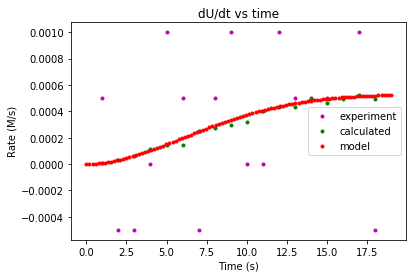

In [14]:
calc_ru_sparse = dudt(x_data, beta3_trial, popt[0])
calc_ru = dudt(B, beta3_trial, popt[0])

# Plot of du/dt obtained from experimental data and calculated du/dt versus time
#plt.plot(exp_t[1:-1], exp_ru, 'm.',
#        exp_t[1:-1], calc_ru, 'r.')
plt.plot(exp_t[1:-1], exp_ru, 'm.', label='experiment')
plt.plot(exp_t[1:-1], calc_ru_sparse, 'g.', label='calculated')
plt.plot(times, calc_ru, 'r.', label='model')
plt.legend()
plt.title('dU/dt vs time')
plt.xlabel('Time (s)')
plt.ylabel('Rate (M/s)')

k3 =  nan 
beta3=  nan


/home/artem/applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
/home/artem/applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log
  """


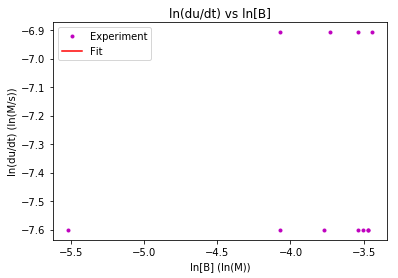

In [15]:
# Plot of ln(du/dt) vs ln([B]) for experimental and calculated data
#plt.plot(np.log(exp_missing_a[1:-1]), np.log(exp_ru), 'm.',
#        np.log(B), np.log(calc_ru), 'r.')
lnB = np.log(exp_missing_a[1:-1])
lnru_exp = np.log(exp_ru)
beta3_fit, lnk3_fit, r_val, p_val, std_err = linregress(lnB, lnru_exp)
plt.plot(lnB, lnru_exp, 'm.', label='Experiment')
plt.plot(lnB, lnk3_fit + beta3_fit * lnB, 'r-', label='Fit')
plt.legend()
plt.title('ln(du/dt) vs ln[B]')
plt.xlabel('ln[B] (ln(M))')
plt.ylabel('ln(du/dt) (ln(M/s))')
print('k3 = ', np.exp(lnk3_fit), '\nbeta3= ', beta3_fit)

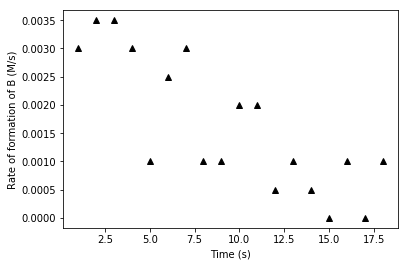

In [16]:
# rB vs time
plt.plot(exp_t[1:-1], exp_r_missing_a, 'k^', label='rB')
plt.xlabel('Time (s)')
plt.ylabel('Rate of formation of B (M/s)')
plt.show()

## Optimization of $k_{-1}$ based on no-catalyst data

In [17]:
x_input = np.stack((exp_a[1:-1], exp_missing_a[1:-1]))
y_input = -1*exp_ra

def dadt_partial(conc_data, k1_trial, k_1_trial):
    cA, cB = conc_data
    return dadt(cA, cB, alpha, beta1, k1_trial, k_1_trial)

popt_ra, pcov_ra = curve_fit(dadt_partial, x_input, y_input)
k_error = np.sqrt(np.diag(pcov))
report(popt_ra, pcov_ra)

Parameter 0: -0.09049583301154658 +/- 0.00496480785791148 (1 st. dev.)
Parameter 1: -1.4226702291321847 +/- 0.22797181443584905 (1 st. dev.)


## Global parameter optimization

In [54]:
def rate_a_partial(conc_data, k1_trial, k_1_trial):
    '''Returns da/dt as a function of [A], [B] and trial constants'''
    A, B = conc_data
    rate_a = dadt(A, B, alpha, beta1, k1_trial, k_1_trial)
    #rate_u = dudt(B, beta3, k3_trial)
    return rate_a

In [55]:
x_gopt = np.stack((exp_a[1:-1], exp_missing_a[1:-1]))
y_gopt = exp_ra

popt_gopt, pcov_gopt = curve_fit(rates_partial, x_gopt, y_gopt)
k_g_error = np.sqrt(np.diag(pcov_gopt))
report(popt_gopt, pcov_gopt)

Parameter 0: 0.21342472629350678 +/- 0.005737550775640185 (1 st. dev.)
Parameter 1: 1.7485604341836478 +/- 0.10151528524825844 (1 st. dev.)


In [18]:
def rate_b_partial(conc_data, k1_trial, k_1_trial, k3_trial):
    '''Returns db/dt as a function of [A], [B], and trial constants
       This only works for catalyst concentrations of 0.
    '''
    A, B = conc_data
    rate_a = dadt(A, B, alpha, beta1, k1_trial, k_1_trial)
    rate_u = dudt(B, beta3, k3_trial)
    rate_b = -1 * rate_a - rate_u
    return rate_b

In [19]:
x_bopt = np.stack((exp_a[1:-1], exp_missing_a[1:-1]))
y_bopt = exp_r_missing_a

popt_bopt, pcov_bopt = curve_fit(rate_b_partial, x_bopt, y_bopt)
k_b_error = np.sqrt(np.diag(pcov_bopt))
report(popt_bopt, pcov_bopt)

Parameter 0: 0.08963728935138826 +/- inf (1 st. dev.)
Parameter 1: -3247.449277145693 +/- inf (1 st. dev.)
Parameter 2: 3249.3522879767156 +/- inf (1 st. dev.)


/home/artem/applications/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
